In [ ]:
import numpy as np
import matplotlib.pyplot as plt
try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

# **Lab 4 - Darcy flow benchmark analysis**


Today we consider a simplified Darcy flow model featuring a spatially distributed parameter (permeability field), namely

$$\begin{cases}-\nabla\cdot(k\nabla p) = f & \text{in}\;\Omega\\-\nabla p\cdot\boldsymbol{n}\equiv0 & \text{on}\;\partial\Omega\\\int_{\Omega}p=0\end{cases}$$

where $\Omega\subset\mathbb{R}^{2}$ is the spatial domain, $p:\Omega\to\mathbb{R}$ is the pressure field and $\boldsymbol{n}$ is the unit normal. The permeability field, $k:\Omega\to(0,+\infty)$ is our parameter. We model it using a random field for which

$$0.1\le k \le 10.1,\quad\quad k\in\mathcal{C}(\Omega),$$

holds $\mathbb{P}$-almost surely. Specifically, we derive the latter as

$$k = 10\mathcal{S}(D e^{-\gamma Z})+0.1$$

where

- $\gamma=1/4$,
- $D:\Omega\to[0,+\infty)$ is a deterministic map, related to the "point-to-boundary-distance",
- $Z$ is a centered Gaussian random field with isotropic covariance kernel $\kappa(r)=e^{-100r^2}$,
- $\mathcal{S}$ is a scaling operator. Precisely, if $g\in\mathcal{C}(\Omega)$ is nonconstant, then $\mathcal{S}(g)$ is defined as

$$\mathcal{S}(g):=\frac{g-\min_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})}{\max_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})-\min_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})}.$$

We are interested in learning the map

$$k\mapsto p,$$

that maps the permeability field onto the corresponding pressure field. Here, as a spatial domain $\Omega$ we consider the Elba Island. As a source term, instead, we consider a superposition of three pointwise sources (of fixed position and intensity),

$$f = \sum_{i=1}^{3}\delta_{\boldsymbol{x}_i},$$

where $\delta_{\boldsymbol{x}_i}$ denotes the Dirac delta at $\boldsymbol{x}_i$.



We shall implement and compare three different approaches:

- a classical **DeepONet**
- a classical **POD-NN** based on dense layers
- a sparse variant of POD-NN, that leverages mesh-informed neural networks (**POD-MINN**)

## Data exploration



In [ ]:
import gdown
gdown.download(id = "1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1", output = "elba_dataset.npz")
gdown.download(id = "16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4", output = "elba_mesh.xml")

Downloading...
From (original): https://drive.google.com/uc?id=1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1
From (redirected): https://drive.google.com/uc?id=1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1&confirm=t&uuid=4aa68fbd-6c50-4a55-9c65-6cbee532e902
To: /content/elba_dataset.npz
100%|██████████| 153M/153M [00:01<00:00, 132MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4
From (redirected): https://drive.google.com/uc?id=16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4&confirm=t&uuid=c65881c2-00a7-4248-9d1c-c124c14cadc9
To: /content/elba_mesh.xml
100%|██████████| 1.93M/1.93M [00:00<00:00, 67.9MB/s]


'elba_mesh.xml'

In [ ]:
dataset = np.load("elba_dataset.npz")
k, pressure = dataset['mu'], dataset['u']

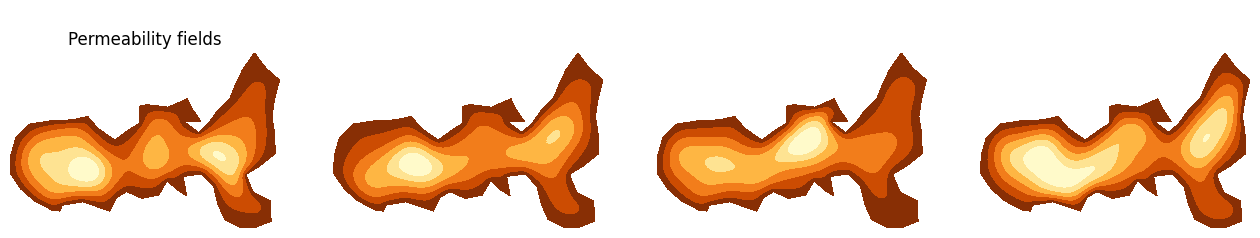

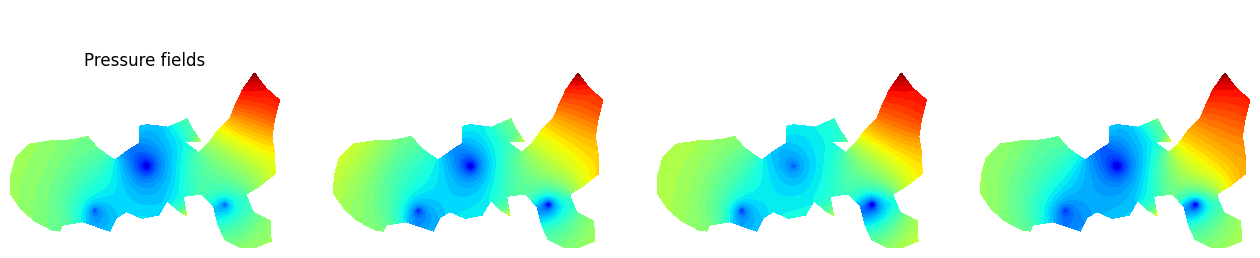

In [ ]:
from IPython.display import clear_output as clc
import matplotlib.pyplot as plt

mesh = fe.loadmesh("elba_mesh.xml")
Vh = fe.space(mesh, "CG", 1)
clc()

fe.multiplot(k[:4], (1, 4), Vh, levels = 7, cmap = 'YlOrBr_r')
plt.subplot(1, 4, 1)
plt.title("\nPermeability fields")

fe.multiplot(pressure[:4], (1, 4), Vh, levels = 50)
plt.subplot(1, 4, 1)
plt.title("\n\nPressure fields")
None

In [ ]:
k.shape, pressure.shape

((1000, 9550), (1000, 9550))

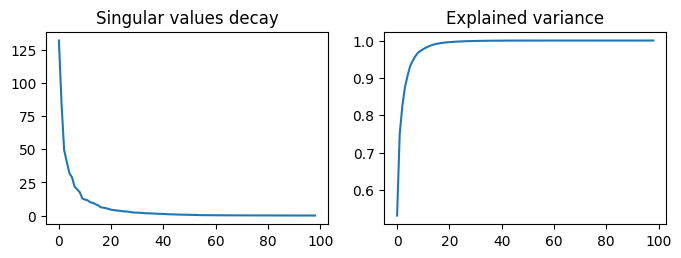

In [ ]:
from scipy.linalg import svd
ntrain = 800
X, s, _ = svd(pressure[:ntrain].T, full_matrices = False)

plt.figure(figsize = (8, 2.5))
plt.subplot(1, 2, 1)
plt.plot(s[1:100])
plt.title("Singular values decay")
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(s[1:100]**2)/np.sum(s[1:]**2))
plt.title("Explained variance")
plt.show()

In [ ]:
n = 15
V = X[:, :n]

In [ ]:
V.shape

(9550, 15)

## Surrogate models

In [ ]:
k, pressure, V = dv.tensor(k, pressure, V)
l2 = L2(Vh)
if(dv == GPU):
  l2.cuda()
clc()

In [ ]:
ptest = pressure[ntrain:]
pproj = ptest @ V @ V.T
mre(l2)(ptest, pproj)

tensor(0.0197, device='cuda:0')

### Classic POD-NN

In [ ]:
c = pressure @ V

#k --> c

In [ ]:
import torch
rho = torch.nn.functional.gelu
p = k.shape[-1]

phi = DFNN(Dense(p, 131, activation = rho) + Dense(131, 50, activation = rho) + Dense(50, n, activation = None))
phi.He()
phi.moveOn(dv)
phi.train(k, c, ntrain = ntrain, nvalid = 100, epochs = 500, loss = mse(euclidean), nstop = 10)

		Train		Valid		Test
Epoch 500:	5.62e+00	1.04e+01	2.50e+01.

>> ETA: 0.57s.

Training complete. Elapsed time: 4 minutes 45.27 seconds.


In [ ]:
phi.freeze()
podnn = lambda kperm : phi(kperm) @ V.T

In [ ]:
print("MRE for POD-NN: %s." % num2p(mrei(l2)(pressure[ntrain:], podnn(k)[ntrain:])))

MRE for POD-NN: 9.26%.


### Mesh-informed enhanced POD-NN (POD-MINN)

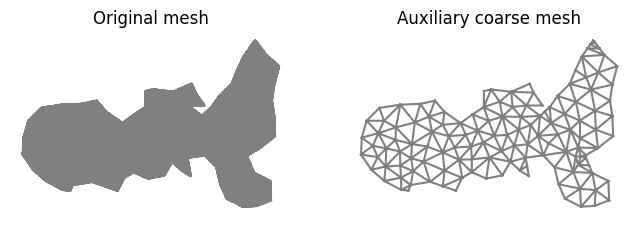

In [ ]:
gdown.download(id = "1_ESzq4c-Q68dImt-WE7G_3PxYduPejBD", output = "elba_coarse_mesh.xml")
cmesh = fe.loadmesh("elba_coarse_mesh.xml")
clc()

plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
fe.plot(mesh)
plt.title("Original mesh")

plt.subplot(1, 2, 2)
fe.plot(cmesh)
plt.title("Auxiliary coarse mesh")
None

In [ ]:
Vc = fe.space(cmesh, 'CG', 1)
clc()

Vc.dim()

131

In [ ]:
minn = DFNN(Local(Vh, Vc, support = 0.1, activation = rho) +
           Dense(131, 50, activation = rho) + Dense(50, n, activation = None))
minn.He()
minn.moveOn(dv)
minn.train(k, c, ntrain = ntrain, nvalid = 100, epochs = 500, loss = mse(euclidean), nstop = 10)

		Train		Valid		Test
Epoch 500:	4.04e-01	9.77e-01	5.46e+00.

>> ETA: 0.30s.

Training complete. Elapsed time: 2 minutes 28.21 seconds.


In [ ]:
minn.freeze()
podminn = lambda kperm : minn(kperm) @ V.T

print("MRE for POD-MINN: %s." % num2p(mrei(l2)(pressure[ntrain:], podminn(k)[ntrain:])))

MRE for POD-MINN: 3.27%.


### DeepONet

In [ ]:
class DeepONetX(ROM):

    def __init__(self, branch, trunk, x):
        super(DeepONetX, self).__init__(branch, trunk)
        self.branch = branch
        self.trunk = trunk
        self.x = x

    def forward(self, mu):
        return self.branch(mu) @ self.trunk(self.x).T

    def parameters(self):
        return self.branch.parameters() + self.trunk.parameters()

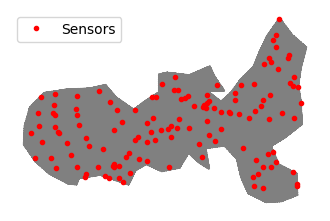

In [ ]:
nsensors = 131
sensors = np.linspace(0, Vh.dim(), nsensors+1).astype('int')[:-1]
plt.figure(figsize = (4, 4))
fe.plot(mesh)
plt.plot(*fe.coordinates(Vh)[sensors].T, '.r', label = 'Sensors')
plt.legend()
plt.show()

In [ ]:
d = 2
m = 15

branch = Dense(nsensors, 131, activation = rho) + Dense(131, 50, activation = rho) + Dense(50, m, activation = None)
trunk  = Dense(d, 100) + Dense(100, 100) + Dense(100, m, activation = None)

xmesh = dv.tensor(fe.coordinates(Vh))
ksens = k[:, sensors]
deeponet = DeepONetX(branch, trunk, xmesh)
deeponet.He()
deeponet.moveOn(dv)
deeponet.train(ksens, pressure, epochs = 20,   ntrain = ntrain, nvalid = 100, loss = mse(l2), error = mre(l2), notation = '%')
deeponet.train(ksens, pressure, epochs = 5000, ntrain = ntrain, nvalid = 100, loss = mse(l2), error = mre(l2), nstop = 10,
               optim = torch.optim.Adam, lr = 1e-4, batchsize = 50, notation = '%')

		Train	Valid	Test
Epoch 3518:	25.90%	27.48%	27.86%.

>> ETA: 1m 57.97s.


KeyboardInterrupt: 

In [ ]:
deeponet.freeze()
print("MRE for DeepONet: %s." % num2p(mrei(l2)(pressure[ntrain:], deeponet(ksens[ntrain:]))))

MRE for DeepONet: 22.96%.


## Comparison at inference

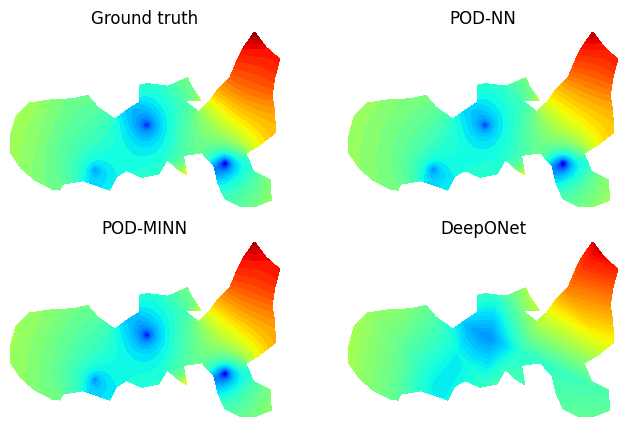

In [ ]:
j = -1
vmin, vmax = pressure[j].min(), pressure[j].max()
plt.figure(figsize = (8, 5))
plt.subplot(2, 2, 1)
fe.plot(pressure[j], Vh, levels = 50, vmin = vmin, vmax = vmax)
plt.title("Ground truth")

plt.subplot(2, 2, 2)
fe.plot(podnn(k[j]), Vh, levels = 50, vmin = vmin, vmax = vmax)
plt.title("POD-NN")

plt.subplot(2, 2, 3)
fe.plot(podminn(k[[j]])[0], Vh, levels = 50, vmin = vmin, vmax = vmax)
plt.title("POD-MINN")

plt.subplot(2, 2, 4)
fe.plot(deeponet(ksens[j]), Vh, levels = 50, vmin = vmin, vmax = vmax)
plt.title("DeepONet")
None

In [ ]:
errors = dict()

for label, model, kperm in zip(["DeepONet", "POD-NN", "POD-MINN"], [deeponet, podnn, podminn], [ksens, k, k]):
  errors[label] = l2(pressure[ntrain:] - model(kperm[ntrain:]))/l2(pressure[ntrain:])
  errors[label] = errors[label].detach().cpu().numpy()

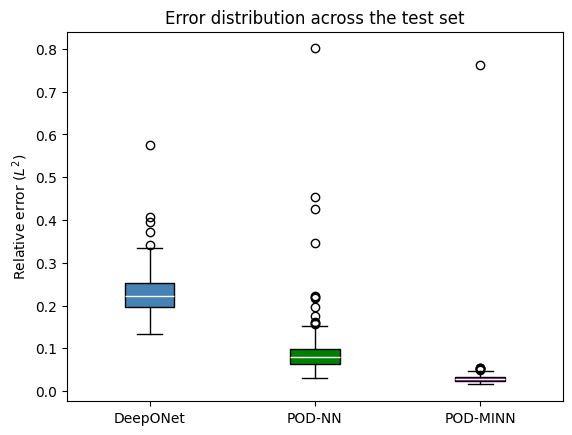

In [ ]:
boxplot(errors, colors = ['steelblue', 'green', 'purple'])
plt.ylabel("Relative error ($L^2$)")
plt.title("Error distribution across the test set")
plt.show()

## Extra (understanding MINNs)

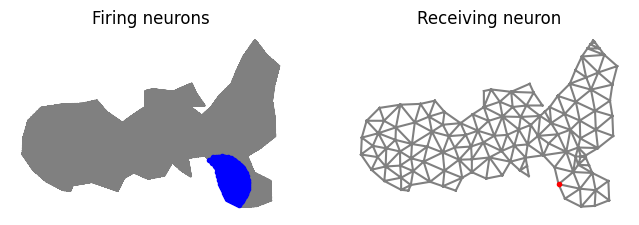

In [ ]:
xmesh = dv.tensor(fe.coordinates(Vh))
mesh_informed_layer = minn[0][0]
i_out = 50
j_in = mesh_informed_layer.W()[:, i_out]!=0

xout = fe.coordinates(Vc)[i_out]

plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
fe.plot(mesh)
plt.plot(xmesh[j_in, 0].cpu().numpy(), xmesh[j_in, 1].cpu().numpy(), '.b')
plt.title("Firing neurons")

plt.subplot(1, 2, 2)
fe.plot(cmesh)
plt.plot(*xout, '.r')
plt.title("Receiving neuron")
None